<a href="https://colab.research.google.com/github/ngohuy1811/AIO-Module-5/blob/main/Exercise_Multilayer_perceptron_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AUTO_MPG**

In [1]:
!gdown 1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu

Downloading...
From: https://drive.google.com/uc?id=1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu
To: /content/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 25.9MB/s]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# Cài đặt giá trị ngẫu nhiên cố định
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# Cài đặt thiết bị tính toán:
device = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')

In [4]:
# Đọc bộ dữ liệu:
dataset_path = '/content/Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)

In [5]:
# Tiền xử lý bộ dữ liệu

# Tách đặc trưng X và nhãn y:
X = dataset.drop(columns ='MPG').values
y = dataset['MPG'].values

In [6]:
# Chia bộ dữ liệu thành tập train và test:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train , X_val , y_train , y_val = train_test_split(
    X , y , test_size = val_size , random_state = random_state, shuffle = is_shuffle
)
X_train , X_test , y_train , y_test = train_test_split(
    X_train , y_train , test_size = test_size , random_state = random_state, shuffle = is_shuffle
)

In [7]:
#Chuẩn hóa đặc trưng đầu vào

normalizer = StandardScaler ()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train , dtype = torch.float32)
X_val = torch.tensor(X_val , dtype = torch.float32)
X_test = torch.tensor(X_test , dtype = torch.float32)
y_train = torch.tensor(y_train , dtype = torch.float32)
y_val = torch.tensor(y_val , dtype = torch.float32)
y_test = torch.tensor(y_test , dtype = torch.float32)


In [8]:
# Create data loader:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx],self.y[idx]

In [9]:
batch_size = 32
train_dataset = CustomDataset(X_train , y_train)
val_dataset = CustomDataset(X_val , y_val)

train_loader = DataLoader(train_dataset , batch_size = batch_size , shuffle = True)
val_loader = DataLoader(val_dataset , batch_size = batch_size , shuffle = False)

In [22]:
# Create MLP:
class MLP(nn.Module):
    def __init__ (self , input_dims , hidden_dims , output_dims ):
        super().__init__()
        self.linear1 = nn.Linear(input_dims , hidden_dims)
        self.linear2 = nn.Linear(hidden_dims , hidden_dims)
        self.output = nn.Linear(hidden_dims , output_dims)

    def forward(self , x):
        x = self.linear1(x)
        x = torch.sigmoid(x)
        #x = torch.sigmoid(x)
        #x = F.relu(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        #x = torch.sigmoid(x)
        #x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [23]:
#Linear regression
class LinearRegression(nn.Module):
    def __init__(self, input_dims, output_dims):
        super().__init__()
        self.linear = nn.Linear(input_dims, output_dims)

    def forward(self, x):
        return self.linear(x).squeeze(1)

In [24]:
# Parameters:
input_dims = X_train.shape[1]
hidden_dims = 64
output_dims = 1

model = MLP(input_dims=input_dims, hidden_dims = hidden_dims ,output_dims=output_dims).to(device)
learning_rate = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)



In [25]:
# Coeficient of determination:
def r_squared (y_true , y_pred ):
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2


In [26]:
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

In [27]:
for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    model.train()

    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        train_predict += outputs.tolist()
        train_target += y_samples.tolist()
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_predict += outputs.tolist()
            val_target += y_samples.tolist()
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict))

    print(f'\nEpoch {epoch+1}/{epochs}:\tTrain Loss: {train_loss:.3f}\tVal Loss: {val_loss:.3f}')



Epoch 1/100:	Train Loss: 154.702	Val Loss: 57.432

Epoch 2/100:	Train Loss: 45.598	Val Loss: 39.028

Epoch 3/100:	Train Loss: 35.270	Val Loss: 25.857

Epoch 4/100:	Train Loss: 26.740	Val Loss: 18.978

Epoch 5/100:	Train Loss: 20.906	Val Loss: 15.328

Epoch 6/100:	Train Loss: 18.542	Val Loss: 9.103

Epoch 7/100:	Train Loss: 16.811	Val Loss: 8.437

Epoch 8/100:	Train Loss: 16.611	Val Loss: 8.375

Epoch 9/100:	Train Loss: 14.083	Val Loss: 7.835

Epoch 10/100:	Train Loss: 13.490	Val Loss: 8.019

Epoch 11/100:	Train Loss: 13.739	Val Loss: 7.358

Epoch 12/100:	Train Loss: 13.011	Val Loss: 9.474

Epoch 13/100:	Train Loss: 12.695	Val Loss: 7.588

Epoch 14/100:	Train Loss: 12.196	Val Loss: 7.079

Epoch 15/100:	Train Loss: 12.015	Val Loss: 7.032

Epoch 16/100:	Train Loss: 11.812	Val Loss: 6.951

Epoch 17/100:	Train Loss: 11.515	Val Loss: 6.790

Epoch 18/100:	Train Loss: 11.343	Val Loss: 7.534

Epoch 19/100:	Train Loss: 10.610	Val Loss: 7.003

Epoch 20/100:	Train Loss: 11.142	Val Loss: 6.613

Ep

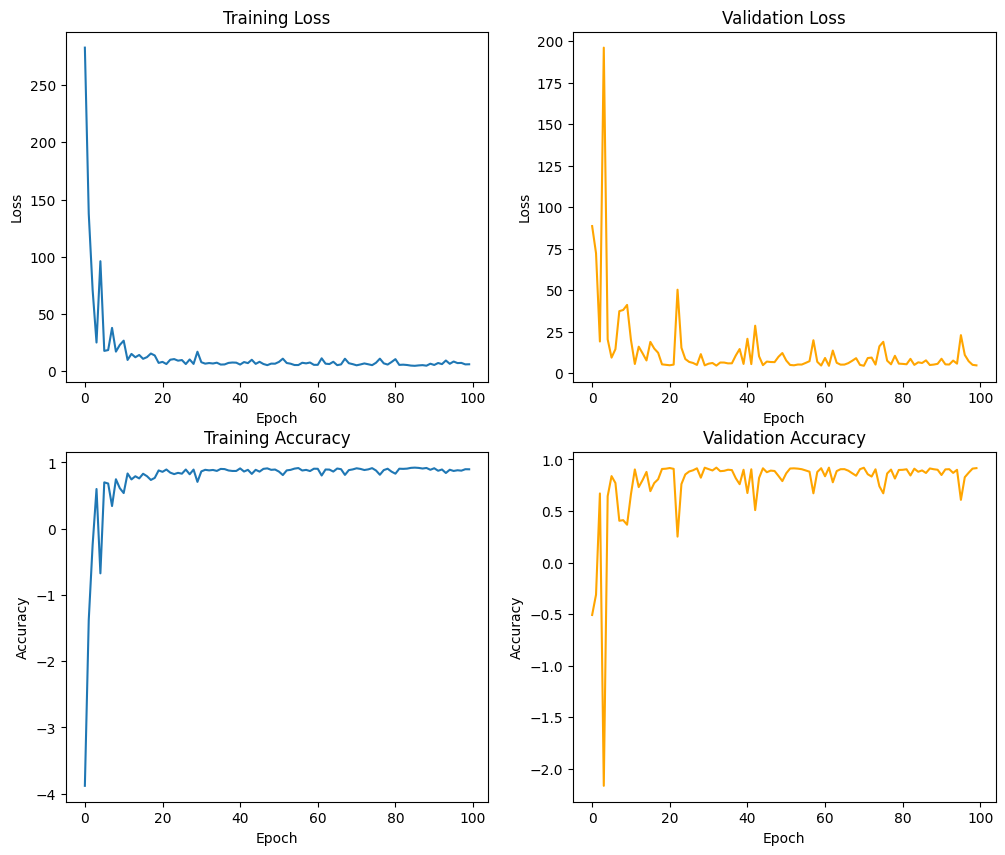

In [ ]:
fig , ax = plt.subplots(2, 2, figsize =(12 , 10))
ax[0 , 0].plot(train_losses)
ax[0 , 0].set(xlabel ='Epoch', ylabel ='Loss')
ax[0 , 0].set_title('Training Loss')

ax[0 , 1].plot(val_losses, 'orange')
ax[0 , 1].set(xlabel='Epoch', ylabel='Loss')
ax[0 , 1].set_title('Validation Loss')

ax[1 , 0].plot(train_r2)
ax[1 , 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1 , 0].set_title('Training Accuracy')

ax[1 , 1].plot(val_r2, 'orange')
ax[1 , 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1 , 1].set_title('Validation Accuracy')

plt.show()

In [28]:
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_set_r2 = r_squared(y_hat, y_test)
    print ('Evaluation on test set :')
    print (f'R2: { test_set_r2 }')

Evaluation on test set :
R2: 0.8256048560142517


# **NonLinear data classsification**

In [29]:
! gdown  1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 14.1MB/s]


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [86]:
# Cài đặt giá trị ngẫu nhiên cố định
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# Cài đặt thiết bị tính toán:
device = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')

In [87]:
data_path = '/content/NonLinear_data.npy'
data = np.load(data_path, allow_pickle = True ).item()
X, y = data ['X'], data ['labels']

print (X.shape, y.shape)

(300, 2) (300,)


In [88]:
# Chia bộ dữ liệu thành tập train và test:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train , X_val , y_train , y_val = train_test_split(
    X , y , test_size = val_size , random_state = random_state, shuffle = is_shuffle
)
X_train , X_test , y_train , y_test = train_test_split(
    X_train , y_train , test_size = test_size , random_state = random_state, shuffle = is_shuffle
)

In [89]:
#Chuẩn hóa đặc trưng đầu vào

normalizer = StandardScaler ()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train , dtype = torch.float32)
X_val = torch.tensor(X_val , dtype = torch.float32)
X_test = torch.tensor(X_test , dtype = torch.float32)
y_train = torch.tensor(y_train , dtype = torch.long)
y_val = torch.tensor(y_val , dtype = torch.long)
y_test = torch.tensor(y_test , dtype = torch.long)


In [90]:
# Create data loader:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx],self.y[idx]

In [91]:
batch_size = 32
train_dataset = CustomDataset(X_train , y_train)
val_dataset = CustomDataset(X_val , y_val)
test_dataset = CustomDataset(X_test , y_test)

train_loader = DataLoader(train_dataset , batch_size = batch_size , shuffle = True)
val_loader = DataLoader(val_dataset , batch_size = batch_size , shuffle = False)
test_loader = DataLoader(test_dataset , batch_size = batch_size , shuffle = True)

In [92]:
# Create MLP:
class MLP(nn.Module):
    def __init__ (self , input_dims , hidden_dims , output_dims ):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims , hidden_dims)
        self.output = nn.Linear(hidden_dims , output_dims)
        #self.relu = nn.ReLU()
        #self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self , x):
        x = self.linear1(x)
        x = self.tanh(x)
        out = self.output(x)
        return out.squeeze(1)

In [93]:
# Create Softmax:
class Softmax(nn.Module):
    def __init__(self, input_dims, output_dims):
        super().__init__()
        self.linear = nn.Linear(input_dims, output_dims)

    def forward(self, x):
        logits = self.linear(x)  # Chỉ một lớp Linear
        probs = F.softmax(logits, dim=1)  # Sử dụng Softmax cho đầu ra
        return probs

In [94]:
input_dims = X_train.shape[1]
hidden_dims = 512
output_dims = torch.unique(y_train).shape[0]

model = MLP(input_dims=input_dims, hidden_dims = hidden_dims ,output_dims=output_dims).to(device)
learning_rate = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

In [95]:
# Accuracy function:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max (y_hat, dim =1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / y_true.shape[0]
    return accuracy


In [96]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples , y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)


    model.eval()
    val_loss = 0.0
    val_target = []
    val_predict = []

    with torch.no_grad():
        for X_samples , y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'\nEpoch {epoch+1}:\tTrain Loss: {train_loss:.3f}\tVal Loss: {val_loss:.3f}')



Epoch 1:	Train Loss: 0.988	Val Loss: 1.308

Epoch 2:	Train Loss: 0.924	Val Loss: 1.023

Epoch 3:	Train Loss: 0.793	Val Loss: 0.934

Epoch 4:	Train Loss: 0.882	Val Loss: 1.078

Epoch 5:	Train Loss: 0.765	Val Loss: 0.960

Epoch 6:	Train Loss: 0.731	Val Loss: 1.038

Epoch 7:	Train Loss: 0.796	Val Loss: 0.938

Epoch 8:	Train Loss: 0.861	Val Loss: 1.007

Epoch 9:	Train Loss: 0.734	Val Loss: 0.809

Epoch 10:	Train Loss: 0.642	Val Loss: 0.810

Epoch 11:	Train Loss: 0.681	Val Loss: 0.768

Epoch 12:	Train Loss: 0.648	Val Loss: 0.788

Epoch 13:	Train Loss: 0.652	Val Loss: 0.855

Epoch 14:	Train Loss: 0.741	Val Loss: 0.650

Epoch 15:	Train Loss: 0.591	Val Loss: 0.713

Epoch 16:	Train Loss: 0.576	Val Loss: 0.670

Epoch 17:	Train Loss: 0.555	Val Loss: 0.694

Epoch 18:	Train Loss: 0.646	Val Loss: 0.731

Epoch 19:	Train Loss: 0.599	Val Loss: 0.877

Epoch 20:	Train Loss: 0.607	Val Loss: 0.784

Epoch 21:	Train Loss: 0.520	Val Loss: 0.722

Epoch 22:	Train Loss: 0.549	Val Loss: 0.667

Epoch 23:	Train Lo

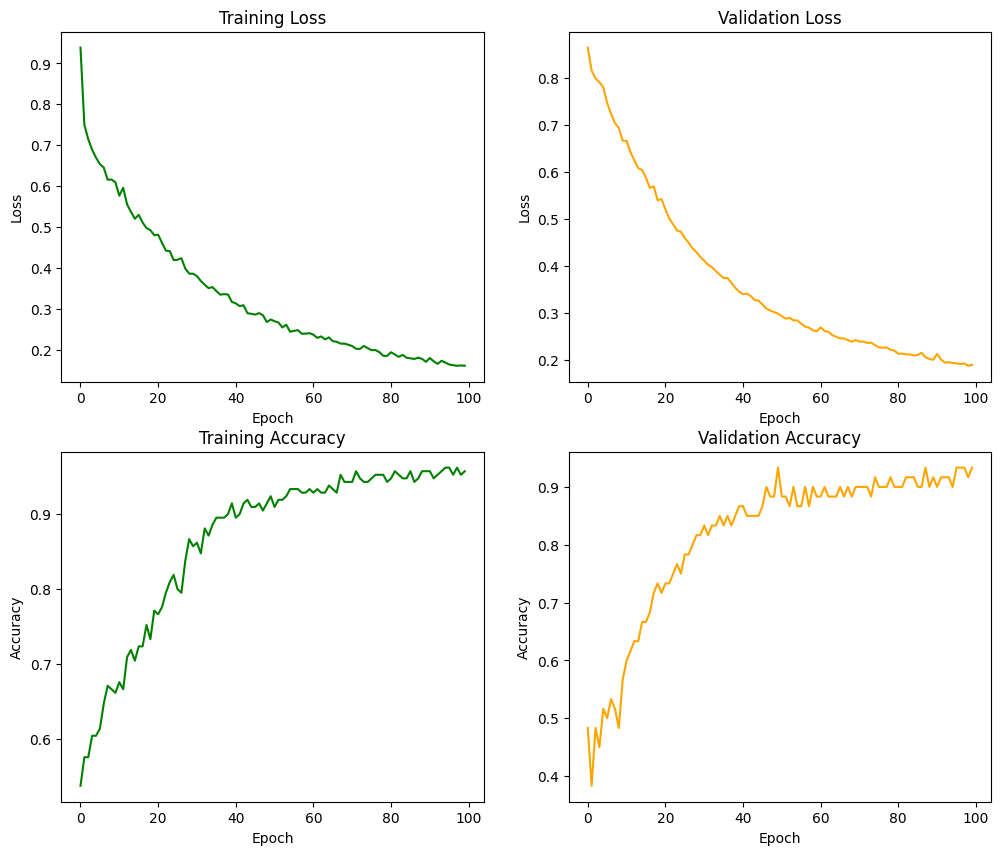

In [ ]:
fig , ax = plt.subplots(2, 2, figsize =(12 , 10))
ax[0 , 0].plot(train_losses, color= 'green')
ax[0 , 0].set(xlabel ='Epoch', ylabel ='Loss')
ax[0 , 0].set_title('Training Loss')

ax[0 , 1].plot(val_losses, 'orange')
ax[0 , 1].set(xlabel='Epoch', ylabel='Loss')
ax[0 , 1].set_title('Validation Loss')

ax[1 , 0].plot(train_accs, color= 'green')
ax[1 , 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1 , 0].set_title('Training Accuracy')

ax[1 , 1].plot(val_accs, 'orange')
ax[1 , 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1 , 1].set_title('Validation Accuracy')

plt.show()

In [97]:
test_target = []
test_predict = []
model.eval()

with torch.no_grad():
    for X_samples , y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = compute_accuracy(test_predict, test_target)
print ('Evaluation on test set :')
print (f'Accuracy: { test_acc }')

Evaluation on test set :
Accuracy: 0.9333333333333333


# **Picture Emotion classification**

In [98]:
! gdown 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=11ad0328-aad2-4453-9145-3b6fa0733e4a
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:00<00:00, 66.0MB/s]


In [99]:
! unzip -q '/content/FER-2013.zip'

In [100]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [130]:
# Cài đặt giá trị ngẫu nhiên cố định
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# Cài đặt thiết bị tính toán:
device = torch.device ('cuda:0' if torch.cuda.is_available () else 'cpu')

In [131]:
# read number of classes in the dataset
train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)

label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls for cls, idx in label2idx.items()}

In [132]:
test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)

print (f'Image height : { img_height }')
print (f'Image width : { img_width }')


Image height : 128
Image width : 128


In [133]:
# Create Data loader:

class ImageDataset(Dataset):
    def __init__ (self, img_dir , norm , label2idx , split ='train', train_ratio =0.8):
        self.resize = Resize((img_height , img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train','val'] and 'train' in img_dir.lower():
            train_data , val_data = train_test_split(
                list(zip(self.img_paths , self.img_labels)),
                train_size = train_ratio ,
                random_state = random_state,
                stratify = self.img_labels
            )

            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)

            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))

                img_labels.append(cls)
        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img/127.5) - 1
        return img, label


In [134]:
# initial train, val, test dataset
batch_size = 256

train_dataset = ImageDataset(train_dir, True, label2idx , split = 'train')

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

val_dataset = ImageDataset(train_dir, True, label2idx , split = 'val')

val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

test_dataset = ImageDataset(test_dir, True, label2idx , split = 'test')

test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)


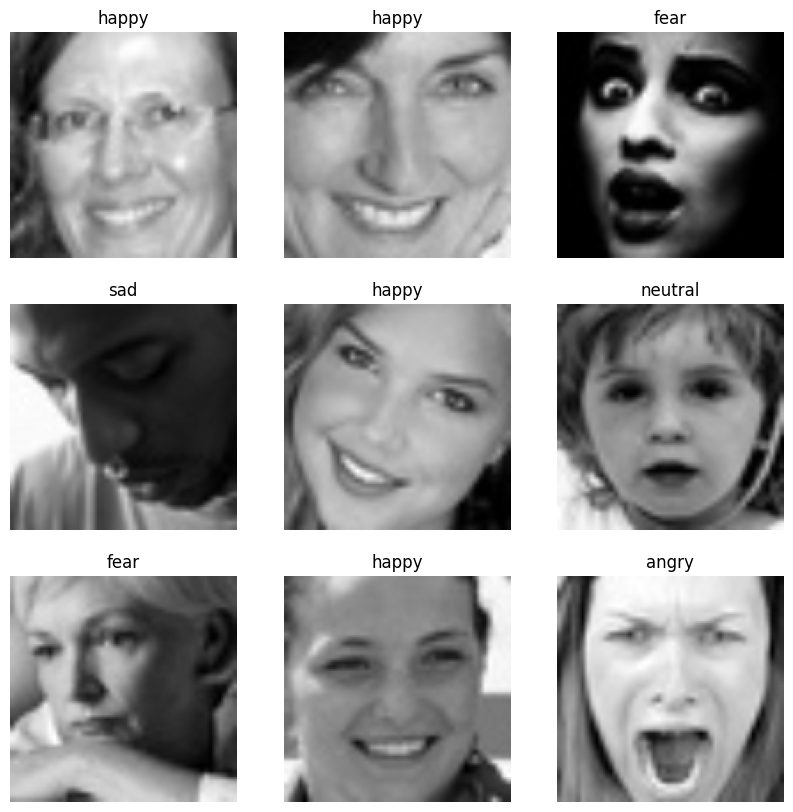

In [135]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10 , 10))
for i in range(9):
    ax = plt.subplot(3 , 3 , i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow (np.squeeze(image_batch[i].numpy()), vmin =minv, vmax=maxv, cmap ='gray')

    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis('off')


In [136]:
# MLP build
class MLP(nn.Module):
    def __init__ (self , input_dims , hidden_dims , output_dims ):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims*4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*4)
        self.linear3 = nn.Linear(hidden_dims*4, hidden_dims*4)
        self.output = nn.Linear(hidden_dims*4, output_dims)

    def forward (self , x) :
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims = input_dims, hidden_dims = hidden_dims, output_dims = output_dims).to(device)



In [137]:
#Loss and opimizer call:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [138]:
#Compute accuracy function:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim =1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

In [139]:
#training
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples , y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)


    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples , y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'\nEpoch {epoch+1}:\tTrain Loss: {train_loss:.3f}\tVal Loss: {val_loss:.3f}')


Epoch 1:	Train Loss: 1.895	Val Loss: 1.849

Epoch 2:	Train Loss: 1.817	Val Loss: 1.799

Epoch 3:	Train Loss: 1.786	Val Loss: 1.781

Epoch 4:	Train Loss: 1.770	Val Loss: 1.767

Epoch 5:	Train Loss: 1.753	Val Loss: 1.750

Epoch 6:	Train Loss: 1.734	Val Loss: 1.730

Epoch 7:	Train Loss: 1.710	Val Loss: 1.708

Epoch 8:	Train Loss: 1.685	Val Loss: 1.685

Epoch 9:	Train Loss: 1.664	Val Loss: 1.669

Epoch 10:	Train Loss: 1.647	Val Loss: 1.657

Epoch 11:	Train Loss: 1.634	Val Loss: 1.647

Epoch 12:	Train Loss: 1.623	Val Loss: 1.639

Epoch 13:	Train Loss: 1.613	Val Loss: 1.634

Epoch 14:	Train Loss: 1.604	Val Loss: 1.624

Epoch 15:	Train Loss: 1.595	Val Loss: 1.618

Epoch 16:	Train Loss: 1.586	Val Loss: 1.613

Epoch 17:	Train Loss: 1.577	Val Loss: 1.608

Epoch 18:	Train Loss: 1.569	Val Loss: 1.603

Epoch 19:	Train Loss: 1.560	Val Loss: 1.597

Epoch 20:	Train Loss: 1.553	Val Loss: 1.594

Epoch 21:	Train Loss: 1.543	Val Loss: 1.590

Epoch 22:	Train Loss: 1.535	Val Loss: 1.586

Epoch 23:	Train Lo

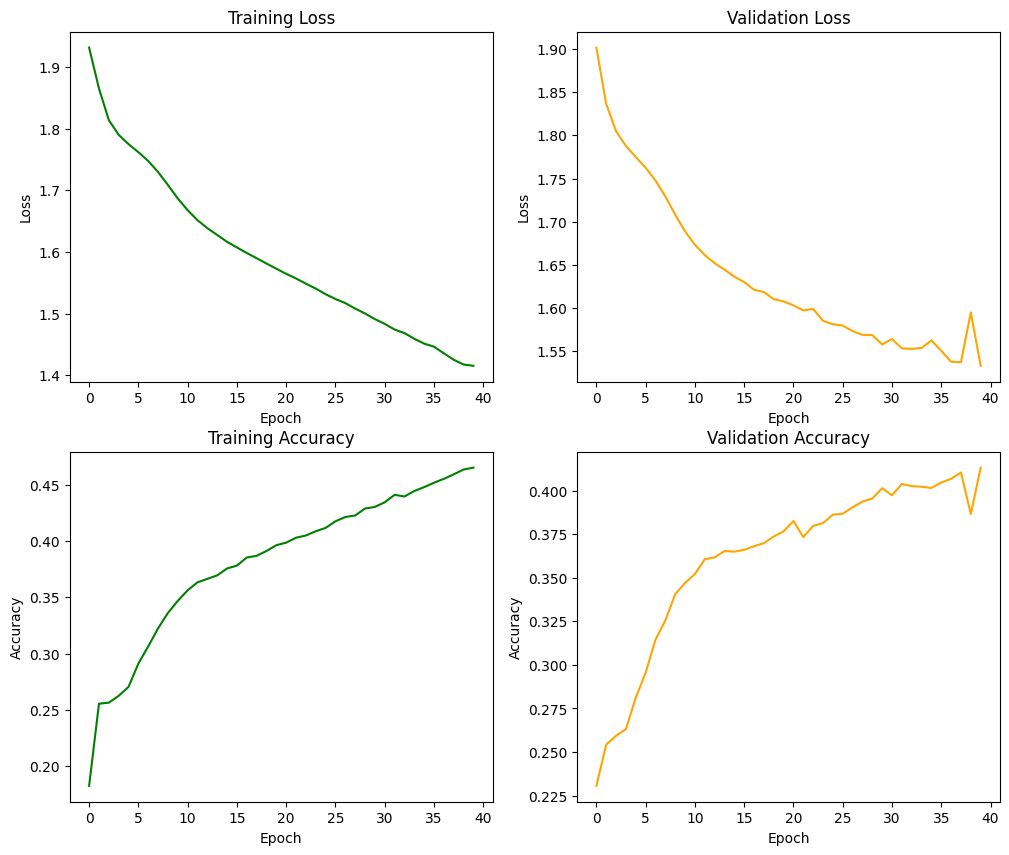

In [ ]:
fig , ax = plt.subplots(2, 2, figsize =(12 , 10))
ax[0 , 0].plot(train_losses, color= 'green')
ax[0 , 0].set(xlabel ='Epoch', ylabel ='Loss')
ax[0 , 0].set_title('Training Loss')

ax[0 , 1].plot(val_losses, 'orange')
ax[0 , 1].set(xlabel='Epoch', ylabel='Loss')
ax[0 , 1].set_title('Validation Loss')

ax[1 , 0].plot(train_accs, color= 'green')
ax[1 , 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1 , 0].set_title('Training Accuracy')

ax[1 , 1].plot(val_accs, 'orange')
ax[1 , 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1 , 1].set_title('Validation Accuracy')

plt.show()

In [140]:
test_target = []
test_predict = []
model.eval()

with torch.no_grad():
    for X_samples , y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = compute_accuracy(test_predict, test_target)
print ('Evaluation on test set :')
print (f'Accuracy: { test_acc }')

Evaluation on test set :
Accuracy: 0.4162719420451379
